# Introduction

This demo is for repairing a neural network that repairs the affine transform neural network example to follow a certain constraint. We perform the folowing operations here:

1. Load the neural network and samples that have both normal and adverserial examples.
2. Define the constraints
3. Define the layer to repair and run the repair


The idea is to repair the layers of the original neural network train in order to ensure the following two cases:

1. If true transformed (rotated) points are following the constraint, the predicted transformed (rotated) points are close to the true transformed (rotated) points as well as follow the constraint; and

2. If true transformed (rotated) points are violating the constraint, the predicted transformed (rotated) points are close to the true transformed (rotated) points but also follow the constraint.

In [1]:
import os
import argparse
from csv import writer
from datetime import datetime
import numpy as np
from affine_utils import (
    plot_dataset,
    model_eval,
    original_data_loader,
    give_polys,
    give_constraints,
)
import tensorflow as tf
from shapely.affinity import scale
from tensorflow import keras
from nnreplayer.utils.options import Options
from nnreplayer.utils.utils import constraints_class
from nnreplayer.repair.repair_weights_class import NNRepair
import pickle

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


2022-04-20 11:36:41.258304: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-20 11:36:42.018157: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 410 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:bd:00.0, compute capability: 7.5
2022-04-20 11:36:42.018774: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 7048 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:91:00.0, compute capability: 6.1


## Initialize Directories to Read/Store Variables

In [3]:
def check_log_directories(path_read, path_write, layer_to_repair):
    """_summary_

    Args:
        path_read (_type_): _description_
        path_write (_type_): _description_

    Raises:
        ImportError: _description_
    """
    if not os.path.exists(path_read + "/model"):
        raise ImportError(f"path {path_read}/model does not exist!")

    if not os.path.exists(path_write):
        os.makedirs(path_write)
        print(f"Directory: {path_write} is created!")

    if not os.path.exists(path_write + "/logs"):
        os.makedirs(path_write + "/logs")

    if not os.path.exists(path_write + "/summery"):
        os.makedirs(path_write + "/summery")

    if not os.path.exists(path_write):
        os.makedirs(path_write + f"/model_layer_{layer_to_repair}")

    if not os.path.exists(path_write + "/stats"):
        os.makedirs(path_write + "/stats")

In [4]:
direc = os.getcwd()
path_read = os.path.join(direc, "original_net")
path_write = os.path.join(direc, "repair_net")



In [5]:
if not os.path.exists(path_read + "/data/input_output_data_tc1.pickle"):
    raise ImportError(
        "path {path_read}/data/input_output_data_tc1.pickle does not exist!"
    )
with open(path_read + "/data/input_output_data_tc1.pickle", "rb") as data:
    dataset = pickle.load(data)
    
x_train, y_train, x_test, y_test = dataset[0], dataset[1], dataset[2], dataset[3]

## Define the Constraints

In [6]:
poly_orig, poly_trans, poly_const = give_polys()
A, b = give_constraints(
    scale(poly_const, xfact=0.98, yfact=0.98, origin="center")
)

# input the constraint list
constraint_inside = constraints_class("inside", A, b)
output_constraint_list = [constraint_inside]
output_constraint_list

[constraints_class(constraint_type='inside', A=array([[-0.70710678, -0.70710678],
        [ 0.70710678, -0.70710678],
        [-0.70710678,  0.70710678],
        [ 0.70710678,  0.70710678]]), B=array([[-2.31053391],
        [ 1.225     ],
        [ 1.225     ],
        [ 4.76053391]]))]

## Repairing Layer 3

Define the Layer to Repair

In [7]:
layer_to_repair = 3

check_log_directories(path_read, path_write, layer_to_repair)



Load the Neural Network

In [8]:
# load model
model_orig = tf.keras.models.load_model( os.path.join(path_read, "model"))

Define Optimizer Options

In [9]:
max_weight_bound = 5
cost_weights = np.array([1.0, 1.0])
options = Options(
    "gdp.bigm",
    "gurobi",
    "python",
    "keras",
    {
        "timelimit": 3600,
        "mipgap": 0.001,
        "mipfocus": 2,
        "improvestarttime": 3300,
        "logfile": path_write
        + f"/logs/opt_log_layer{layer_to_repair}.log",
    },
)


Start Repair

In [10]:
repair_obj = NNRepair(model_orig)

# print(f)
repair_obj.compile(
    x_train,
    y_train,
    layer_to_repair,
    output_constraint_list=output_constraint_list,
    cost_weights=cost_weights,
    max_weight_bound=max_weight_bound,
)
out_model = repair_obj.repair(options)

out_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MeanSquaredError(name="MSE"),
    metrics=["accuracy"],
)

Activating Last layer
Set parameter TimeLimit to value 3600
Set parameter MIPGap to value 0.001
Set parameter MIPFocus to value 2
Set parameter ImproveStartTime to value 3300
Set parameter LogFile to value "/home/local/ASUAD/tkhandai/nn_repair/NNRepLayer_v2/demos/Affine Transform Demo Tensorflow/repair_net/logs/opt_log_layer3.log"
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 1536 rows, 664 columns and 8736 nonzeros
Model fingerprint: 0xdd5cc274
Model has 631 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-04, 4e+00]
  Objective range  [4e-03, 4e-02]
  QObjective range [1e-02, 2e+00]
  Bounds range     [5e+00, 1e+01]
  RHS range        [2e-04, 5e+00]
Presolve removed 426 rows and 3 columns
Presolve time: 0.01s
Presolved: 1110 rows, 1081 columns, 8304 nonzeros
Presolved model has 631 quadratic objective terms
Ordering time: 0.01s

Barrier statistics:
 

In [11]:
repair_obj.summary(direc=path_write + "/summery")

In [12]:
keras.models.save_model(
    out_model,
    path_write + f"/model_layer_{layer_to_repair}",
    overwrite=True,
    include_optimizer=False,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True,
)


2022-04-20 11:36:43.371771: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/local/ASUAD/tkhandai/nn_repair/NNRepLayer_v2/demos/Affine Transform Demo Tensorflow/repair_net/model_layer_3/assets


In [13]:
with open(
    path_write
    + f"/stats/repair_layer{layer_to_repair}_accs_stats_tc1.csv",
    "a+",
    newline="",
) as write_obj:
    # Create a writer object from csv module
    csv_writer = writer(write_obj)
    model_evaluation = model_eval(
        out_model,
        keras.models.load_model(path_read + "/model"),
        path_read,
        poly_const,
    )
    for key, item in options.optimizer_options.items():
        model_evaluation.append(key)
        model_evaluation.append(item)
    model_evaluation.append("max_weight_bound")
    model_evaluation.append(max_weight_bound)
    model_evaluation.append("cost weights")
    model_evaluation.append(cost_weights)
    model_evaluation.append(str(datetime.now()))
    # Add contents of list as last row in the csv file
    csv_writer.writerow(model_evaluation)

In [14]:
model_evaluation

[0.019645344465970993,
 0.03301580995321274,
 1.0,
 0.972972972972973,
 4.77882693879004,
 0.8681913459474756,
 0.16725165396928787,
 'timelimit',
 3600,
 'mipgap',
 0.001,
 'mipfocus',
 2,
 'improvestarttime',
 3300,
 'logfile',
 '/home/local/ASUAD/tkhandai/nn_repair/NNRepLayer_v2/demos/Affine Transform Demo Tensorflow/repair_net/logs/opt_log_layer3.log',
 'max_weight_bound',
 5,
 'cost weights',
 array([1., 1.]),
 '2022-04-20 11:36:44.520755']

----------------------
Data samples Visualization (training)


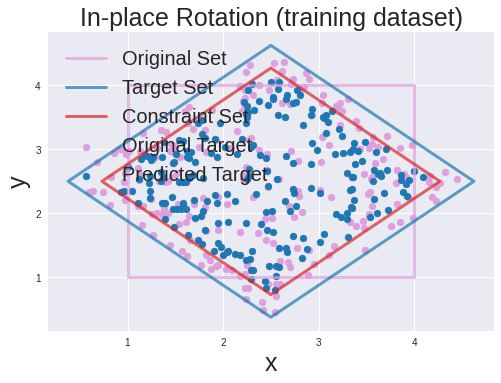

----------------------
Data samples Visualization (testing)


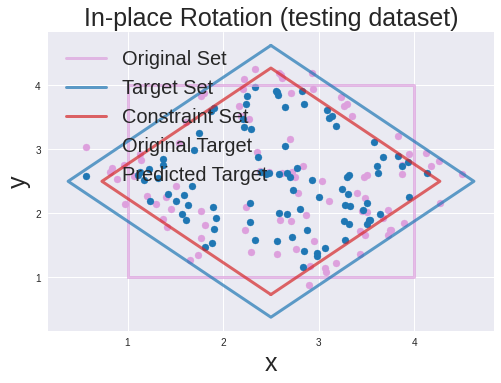

In [15]:
plot_dataset(
    [poly_orig, poly_trans, poly_const],
    [y_train, out_model.predict(x_train)],
    label="training",
)
plot_dataset(
    [poly_orig, poly_trans, poly_const],
    [y_test, out_model.predict(x_test)],
    label="testing",
)